In [ ]:
from paths import *
import pandas as pd
import os
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import joblib



In [5]:
def lmm_model(data_analyte, maxiter=1000):
    le = LabelEncoder()
    data_analyte['Disease_label'] = le.fit_transform(data_analyte['Group Name'])
    data_analyte['Gender_label'] = le.fit_transform(data_analyte['Gender'])
    data_analyte['site'] = data_analyte['Client Sample ID'].str[:3]
    data_analyte['site'] = data_analyte['site'].astype("int")
    data_analyte = data_analyte[["Result", "Disease_label", "Age", "BMI", "Gender_label", "site", "house"]]
    '''
    In the LMM model here, we consider site and house as crossed random effects (because each site holds household pairs)
    This crossed random effect is implemented in the model (as shown below) based on these references:
        https://www.statsmodels.org/stable/mixed_linear.html
        https://stackoverflow.com/questions/59359568/from-2d-to-1d-how-to-pass-a-second-random-effect-in-mixed-model-python-statsm)
        https://www.statsmodels.org/devel/generated/statsmodels.regression.mixed_linear_model.MixedLM.from_formula.html#statsmodels.regression.mixed_linear_model.MixedLM.from_formula
    '''
    data_analyte["group"] = 1    # all in the case group 
    re_formula = "~(1|site) + (1|house)" 
    vcf = {"site": "0 + C(site)", "house": "0 + C(house)"}  # formula selected for the variance-covariance structure of the random effects in LMM
    formula = "Result ~ Disease_label + Age + BMI + Gender_label"
    model = sm.MixedLM.from_formula(formula, 
                                 data_analyte, 
                                 groups=data_analyte['group'], 
                                 re_formula=re_formula,
                                 vc_formula=vcf)
    print("Fitting the model...")
    mdf = model.fit(maxiter=maxiter)
    print("Completed model fitting!")
    return mdf




## Loading data of Targeted compounds

In [6]:
'''
Note that, here we are taking all samples without applying the threshold of "Analysis Comment". This is because,
if we apply the threshold, each analyte will have different number of patient samples.
Hence, there could be a sample effect on the parameter estimation, for e.g. one analyte's parameter may be estimated
from N1 samples and the other analyte's parameter estimated from N2 samples. If N2<<N1, then the estimated model parameters
maynot be comparable. Hence, to ensure that all analyte's model parameters are estimated from the same set of patient samples,
we are not applying this "Analysis Comment" threshold.
'''

sample = "serum"

filename = SHORT_CHAIN_FATTY_ACID_DATA_FILENAME
mapping_filename = "short_chain_fatty_acid_spoke_map.csv"
file_path = os.path.join(DATA_ROOT_PATH, filename)
mapping_filepath = os.path.join(OUTPUT_PATH, mapping_filename)
data = pd.read_excel(file_path, engine='openpyxl')
data = data[data["Client Matrix"]==sample]
mapping_data = pd.read_csv(mapping_filepath)
analytes = mapping_data["name"].unique()
data.head()


,Unique Tube Label ID,Client Sample ID,Client Matrix,Sample Description,Group Name,Treatment,Gender,Age,BMI,Race / Ethnicity,Analyte,Result,Unit,Dilution Factor,LLOQ,ULOQ,Analysis Comment
1000,FS10431265,71701-0004,serum,serum,MS,Treated,F,52.0,19.422970,Caucasian/Hispanic,2-Methylbutyric acid,73.66340,ng/mL,1,25,2500,NaN
1001,FS10431273,71601-0150,serum,serum,MS,Off,F,51.0,25.501750,Caucasian/Hispanic,2-Methylbutyric acid,48.47522,ng/mL,1,25,2500,NaN
1002,FS10431281,71602-0150,serum,serum,Control,Control,M,52.0,34.970939,Caucasian/Hispanic,2-Methylbutyric acid,38.87322,ng/mL,1,25,2500,NaN
1003,FS10431289,71601-0164,serum,serum,MS,Treated,M,56.0,26.544467,Caucasian/Hispanic,2-Methylbutyric acid,129.41031,ng/mL,1,25,2500,NaN
1004,FS10431297,71602-0164,serum,serum,Control,Control,F,53.0,31.176140,Caucasian/Hispanic,2-Methylbutyric acid,85.74194,ng/mL,1,25,2500,NaN


In [ ]:
"""
Data will be pre-processed as follows:
    1. Remove patients with missing values (remove their paired partner too even if they have all values. This is to balance the data in terms of the diet)
    2. Remove patients with outlier values in the specific analyte concentration (also their paired partner, for the same reason mentioned above)

Build 2 models (for each sample serum/feces):
    Model 1 - Stringent model 
        This model uses the fully pre-processed data as mentioned above. Hence, it does not use outlier and missing values.
    Model 2 - Less stringent model
        This model uses partially pre-processed data. i.e. data obtained after removing missing values (point 1 of pre-processing).
        Hence, it uses outlier values and no missing values.

Even though we compute Model 1 for all analytes, for the downstream analysis, we may only consider those Model 1 models of analytes for which there exists at least 800 patient samples after pre-processing.
"""


## Check count of patient samples for each analyte after pre-processing

In [ ]:
data['house'] = data['Client Sample ID'].str[:3] + data['Client Sample ID'].str[-4:]
data['house'] = data['house'].astype("int")
data_exclude_outlier_threshold_column = data.drop("Analysis Comment", axis=1)
house_to_exclude = data_exclude_outlier_threshold_column[data_exclude_outlier_threshold_column.isna().any(axis=1)].house.values
data_nan_removed = data[~data["house"].isin(house_to_exclude)]

data_outlier_removed = data_nan_removed[data_nan_removed["Analysis Comment"].isna()]
data_outlier_removed.drop("Analysis Comment", axis=1, inplace=True)


#Removing unpaired house for each analyte after removing the outliers, so that we get paired MS and control patients

#Step 1: Group by "Analyte" and "house" and count the number of occurrences of each group
group_counts = data_outlier_removed.groupby(['Analyte', 'house']).size()

#Step 2: Get the list of index values where the count is 2
valid_index = group_counts[group_counts == 2].reset_index().set_index(['Analyte', 'house']).index

#Step 3: Filter the DataFrame to keep only the rows with paired "house" values for each "Analyte"
data_outlier_removed = data_outlier_removed.set_index(['Analyte', 'house']).loc[valid_index].reset_index()

analyte_sample_count_after_pre_processing = data_outlier_removed.groupby('Analyte')['Unique Tube Label ID'].nunique().to_dict()



In [8]:
analyte_sample_count_after_pre_processing

{'2-Methylbutyric acid': 996,
 'Acetic acid': 846,
 'Butyric acid': 856,
 'Hexanoic acid': 340,
 'Isobutyric acid': 996,
 'Isovaleric acid': 994,
 'Propionic acid': 398,
 'Valeric acid': 8}

## Plotting the final count of patient samples after pre-processing

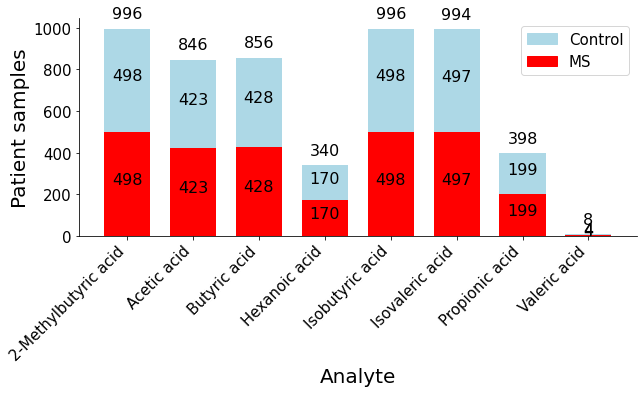

Saving the figure ...


In [9]:
fontsize = 20
figsize = (10,4)

fig = plt.figure(figsize=figsize)

ax = plt.gca()

# group the data by analyte and group name, and get the unique count of unique tube label ID
grouped = data_outlier_removed.groupby(['Analyte', 'Group Name'])['Unique Tube Label ID'].nunique().reset_index()

# pivot the table to get the count for each group name as separate columns
pivoted = grouped.pivot(index='Analyte', columns='Group Name', values='Unique Tube Label ID')

# create the bar plot for each analyte
for i, analyte in enumerate(pivoted.index):
    ms_count = pivoted.loc[analyte, 'MS']
    control_count = pivoted.loc[analyte, 'Control']
    total_count = ms_count + control_count    
    
    # plot red bar for MS count
    ax.bar(i, ms_count, color='red', width=0.7, align='center')
    # plot light blue bar for control count
    ax.bar(i, control_count, color='lightblue', width=0.7, align='center', bottom=control_count)
    # add the total count above the bars
    ax.text(i, total_count+50, f'{total_count}', ha='center', fontsize=fontsize-4)
    # add the count for each group name on top of the bars
    ax.text(i, control_count/2, f'{control_count}', ha='center', fontsize=fontsize-4, color='black')
    ax.text(i, control_count+ms_count/2, f'{ms_count}', ha='center', fontsize=fontsize-4, color='black')

# set the x-axis labels to be the analyte names
ax.set_xticks(range(len(pivoted.index)))
ax.set_xticklabels(pivoted.index, fontsize=12, rotation=45, ha='right')

# set the y-axis label and tick labels
# ax.set_ylabel('Unique Tube Label ID Count', fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set the x label and title
plt.xlabel('Analyte',fontsize=fontsize)
plt.ylabel('Patient samples',fontsize=fontsize)

plt.xticks(rotation=45, fontsize=fontsize-5)
plt.yticks(fontsize=fontsize-5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# add legend box
blue_patch = mpatches.Patch(color='lightblue', label='Control')
red_patch = mpatches.Patch(color='red', label='MS')
plt.legend(handles=[blue_patch, red_patch], fontsize=fontsize-5)
plt.show()

print('Saving the figure ...')
fig_filename = os.path.join(OUTPUT_PATH, "figures", "shortChain_fattyAcid_patient_counts_{}_sample.svg".format(sample))
fig.savefig(fig_filename, format='svg', bbox_inches='tight')


## Linear Mixed Effects Models (LMM) with fully pre-processed data (This takes < 2 min to run)

In [ ]:
analyte_stringent_model_list = []
for analyte in tqdm(analytes):
    mdf = lmm_model(data_outlier_removed[data_outlier_removed["Analyte"] == analyte], maxiter=10000)
    analyte_stringent_model_list.append({"analyte": analyte, 
                                         "patient_sample_count":analyte_sample_count_after_pre_processing[analyte], 
                                         "model": mdf})
    
joblib.dump(analyte_stringent_model_list, os.path.join(OUTPUT_PATH, "shortChain_fattyAcid_stringentModel.joblib"))


## LMM using data with outlier values, but excluding missing data (This takes ~2hr to run)


In [ ]:
analyte_less_stringent_model_list = []
for analyte in tqdm(analytes):
    mdf = lmm_model(data_nan_removed[data_nan_removed["Analyte"] == analyte], maxiter=10000)
    analyte_less_stringent_model_list.append({"analyte": analyte, 
                                              "patient_sample_count":data_nan_removed[data_nan_removed["Analyte"] == analyte].shape[0], 
                                              "model":mdf})

joblib.dump(analyte_less_stringent_model_list, os.path.join(OUTPUT_PATH, "shortChain_fattyAcid_less_stringentModel.joblib"))


## LMM on MS patients who undergoes treatment (along with their control pairs, this takes ~21 seconds to run)

In [35]:
house_to_include = data_outlier_removed[data_outlier_removed.Treatment=="Treated"]["house"].unique()
data_outlier_removed_ms_treated = data_outlier_removed[data_outlier_removed.house.isin(house_to_include)]
print("There are {} MS patients that undergo treatment".format(house_to_include.shape[0]))
print("Hence, total samples = ", data_outlier_removed_ms_treated["Unique Tube Label ID"].unique().shape[0])

analyte_stringent_model_ms_treated_list = []
for analyte in tqdm(analytes):
    try:
        mdf = lmm_model(data_outlier_removed_ms_treated[data_outlier_removed_ms_treated["Analyte"] == analyte], maxiter=10000)
    except: 
        mdf = None
    analyte_stringent_model_ms_treated_list.append({"analyte": analyte, 
                                     "patient_sample_count": data_outlier_removed_ms_treated[data_outlier_removed_ms_treated["Analyte"] == analyte].shape[0], 
                                     "model": mdf})

joblib.dump(analyte_stringent_model_ms_treated_list, os.path.join(OUTPUT_PATH, "shortChain_fattyAcid_stringentModel_MS_treated.joblib"))
    

There 267 MS patients that undergo treatment
Hence, total samples =  534


## LMM on MS patients that are not undergoing treatment (along with their control pairs, this takes 15 seconds to run)

In [51]:
house_to_include = data_outlier_removed[data_outlier_removed.Treatment=="Off"]["house"].unique()
data_outlier_removed_ms_not_treated = data_outlier_removed[data_outlier_removed.house.isin(house_to_include)]
print("There are {} MS patients that do not undergo treatment".format(house_to_include.shape[0]))
print("Hence, total samples = ", data_outlier_removed_ms_not_treated["Unique Tube Label ID"].unique().shape[0])

analyte_stringent_model_ms_not_treated_list = []
for analyte in tqdm(analytes):
    try:
        mdf = lmm_model(data_outlier_removed_ms_not_treated[data_outlier_removed_ms_not_treated["Analyte"] == analyte], maxiter=10000)
    except:
        mdf = None
    analyte_stringent_model_ms_not_treated_list.append({"analyte": analyte, 
                                     "patient_sample_count": data_outlier_removed_ms_not_treated[data_outlier_removed_ms_not_treated["Analyte"] == analyte].shape[0], 
                                     "model": mdf})
    
joblib.dump(analyte_stringent_model_ms_not_treated_list, os.path.join(OUTPUT_PATH, "shortChain_fattyAcid_stringentModel_MS_not_treated.joblib"))
        
        

There are 231 MS patients that do not undergo treatment
Hence, total samples =  462


In [172]:
# # Get predicted values and residuals from the mixed effects model
# predicted_values = mdf.predict()
# residuals = mdf.resid

# # Create the plot
# plt.scatter(predicted_values, residuals, alpha=0.5)
# plt.xlabel("Predicted Values")
# plt.ylabel("Residuals")
# plt.title("Residual vs Predicted Value Plot")
# # plt.axhline(y=0, color='r', linestyle='--') # Add a horizontal line at y=0 for reference
# plt.show()




# def get_data(data_type, sample):
#     data_chemical_annotation = []
#     data_sample_metadata = []
#     if data_type == "targeted":
#         filename = SHORT_CHAIN_FATTY_ACID_DATA_FILENAME
#         mapping_filename = "short_chain_fatty_acid_spoke_map.csv"
#         file_path = os.path.join(DATA_ROOT_PATH, filename)
#         mapping_filepath = os.path.join(OUTPUT_PATH, mapping_filename)
#         data = pd.read_excel(file_path, engine='openpyxl')
#         data = data[data["Client Matrix"]==sample]
# #         data = data[data["Analysis Comment"].isna()]
#         mapping_data = pd.read_csv(mapping_filepath)
#         analytes = mapping_data["name"].unique()
#     elif data_type == "global":
#         sheet_name = ["Chemical Annotation", "Sample Meta Data", "Log Transformed Data"]
#         mapping_filename = "global_metabolomics_compound_spoke_map.csv"
#         if sample == "serum":
#             filename = GLOBAL_SERUM_DATA_FILENAME
#         else:
#             filename = GLOBAL_STOOL_DATA_FILENAME
#         file_path = os.path.join(DATA_ROOT_PATH, filename)
#         mapping_filepath = os.path.join(OUTPUT_PATH, mapping_filename)
#         data_chemical_annotation = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[0])
#         data_sample_metadata = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[1])
#         data = pd.read_excel(file_path, engine='openpyxl', sheet_name=sheet_name[2])
#         mapping_data = pd.read_csv(mapping_filepath)
#         analytes = mapping_data["CHEM_ID"].unique()
#     return data, mapping_data, analytes, data_chemical_annotation, data_sample_metadata


